# Data Preparation

In [17]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import seaborn as sns
import pandas as pd

# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_file = 'gpt_neo_fraud.keras'

Keras = 3.8.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Dataset

In [ ]:
import os
import pandas as pd

# Define the directory for saving the combined dataset
base_dir = "/content/drive/My Drive/SIT_Capstone/"
csv_file = os.path.join(base_dir, "combined_convo_dataset.csv")

# Define the paths for your datasets
splits = {
    'train': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_train.csv',
    'test': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_test.csv',
    'multi_agent_train': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_train.csv',
    'multi_agent_test': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_test.csv',
    'single_agent_train': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_train.csv',
    'single_agent_test': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_test.csv'
}
gen_convo_path = "hf://datasets/BothBosu/Scammer-Conversation/gen_conver_noIdentifier_1000.csv"

# Load datasets
try:
    train_df = pd.read_csv(splits['train'])
    test_df = pd.read_csv(splits['test'])
    multi_agent_train_df = pd.read_csv(splits['multi_agent_train'])
    multi_agent_test_df = pd.read_csv(splits['multi_agent_test'])
    single_agent_train_df = pd.read_csv(splits['single_agent_train'])
    single_agent_test_df = pd.read_csv(splits['single_agent_test'])
    gen_convo_df = pd.read_csv(gen_convo_path)

    # Standardize column naming
    for df in [train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df]:
        # Rename 'dialogue' or 'conversation' to 'conversation'
        if 'dialogue' in df.columns:
            df.rename(columns={'dialogue': 'conversation'}, inplace=True)
        elif 'conversation' not in df.columns:
            raise ValueError("Missing both 'dialogue' and 'conversation' columns in one of the datasets.")

        # Rename 'labels' to 'label' if present
        if 'labels' in df.columns:
            df.rename(columns={'labels': 'label'}, inplace=True)

    # Combine datasets into one
    combined_df = pd.concat([train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df], ignore_index=True)

    # Save the combined dataset
    combined_df.to_csv(csv_file, index=False)
    print("Combined dataset saved successfully!")

    # Print details
    print("First 5 rows of the combined dataset:")
    print(combined_df.head())

    # Total count of rows in the combined dataset
    total_count = len(combined_df)
    print(f"\nTotal number of rows in the combined dataset: {total_count}")

    # Count of each label
    if 'label' in combined_df.columns:
        label_counts = combined_df['label'].value_counts()
        print("Count of each label:")
        print(label_counts)
    else:
        print("Warning: No 'label' column found in the combined dataset.")

except Exception as e:
    print(f"An error occurred: {e}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-3-675f08f7ad6d>:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shuffled_df = combined_df.groupby('source').apply(lambda x: x.sample(frac=1, random_state=42)).reset_index

Shuffled combined dataset saved successfully!
First 5 rows of the shuffled dataset:
                                        conversation type  label     source  \
0  Person A: Hey, how's it going? Person B: It's ...  NaN      0  gen_convo   
1  Person A: Good morning, I'm calling from the s...  NaN      1  gen_convo   
2  Person A: Hey, how's it going? Person B: It's ...  NaN      0  gen_convo   
3  Person A: Hey, how's it going? Person B: It's ...  NaN      0  gen_convo   
4  Person A: Hey, how's it going? Person B: It's ...  NaN      0  gen_convo   

  personality  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

Total number of rows in the shuffled dataset: 5800
Count of each label in shuffled dataset:
label
1    2924
0    2876
Name: count, dtype: int64


# Data Cleaning

In [ ]:
# Remove duplicates
combined_df = combined_df.drop_duplicates()
print(f"Total rows after removing duplicates: {len(combined_df)}")

# Print new label_counts
label_counts = combined_df['label'].value_counts()
print(label_counts)

Total rows after removing duplicates: 5557
label
0    2839
1    2718
Name: count, dtype: int64


# Ratio of Normal to Fraud data Distribution

Ratio of normal to fraud: 0.91
Normal label percentage: 47.60%
Fraud label percentage: 52.40%


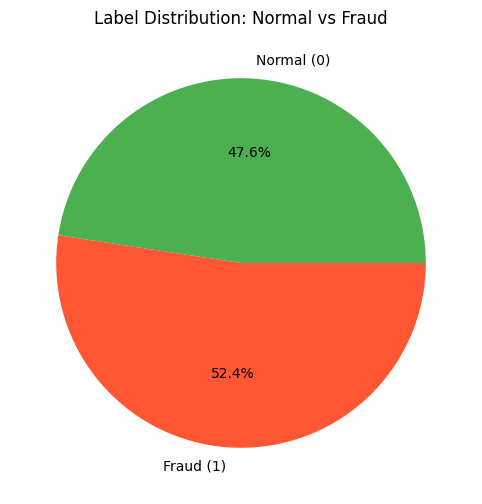

In [5]:
# Count the occurrences of each label dynamically
label_counts = df['label'].value_counts().to_dict()

# Total number of entries
total_count = sum(label_counts.values())

# Extract counts for fraud (1) and normal (0) labels
normal_count = label_counts.get(0, 0)
fraud_count = label_counts.get(1, 0)

# Calculate the ratio of normal to fraud
if fraud_count > 0:  # Avoid division by zero
    ratio = normal_count / fraud_count
else:
    ratio = float('inf')  # If no fraud cases, set ratio to infinity

# Print the ratio and percentages
print(f"Ratio of normal to fraud: {ratio:.2f}")
print(f"Normal label percentage: {(normal_count / total_count) * 100:.2f}%")
print(f"Fraud label percentage: {(fraud_count / total_count) * 100:.2f}%")

# Visualize the label distribution as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    [normal_count, fraud_count],
    labels=['Normal (0)', 'Fraud (1)'],
    autopct='%1.1f%%',
    colors=['#4CAF50', '#FF5733']
)
plt.title('Label Distribution: Normal vs Fraud')
plt.show()

# Model Building

In [6]:
pip install transformers datasets torch scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification, AdamW, get_scheduler
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Initialize the GPT-Neo tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125M", cache_dir="./models")
tokenizer.pad_token = tokenizer.eos_token  # Add padding token for GPT models

# Select only the required columns
X = combined_df['conversation']  # Features
y = combined_df['label']         # Target

# Split the dataset into training and testing sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
def tokenize_texts(texts, tokenizer, max_length=256):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

print("Tokenizing training data...")
train_encodings = tokenize_texts(X_train, tokenizer)
print("Tokenizing testing data...")
test_encodings = tokenize_texts(X_test, tokenizer)

# Convert labels to torch tensors for binary classification
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Print dataset statistics
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
avg_length = X.apply(lambda x: len(x.split())).mean()
print(f"Average text length: {avg_length}")
print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Testing label distribution:\n{y_test.value_counts()}")

# Convert tokenized inputs into TensorDataset
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)

Tokenizing training data...
Tokenizing testing data...
Training set size: 4445
Testing set size: 1112
Average text length: 316.7876552096455
Training label distribution:
label
0    2276
1    2169
Name: count, dtype: int64
Testing label distribution:
label
0    563
1    549
Name: count, dtype: int64


In [8]:
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load GPT-Neo model for binary classification
model = GPTNeoForSequenceClassification.from_pretrained(
    "EleutherAI/gpt-neo-125M",
    num_labels=2  # Binary classification
)
model.config.pad_token_id = tokenizer.eos_token_id
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training configurations
epochs = 10
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

# Define learning rate scheduler
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Training and validation loop
history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
best_val_loss = float("inf")
early_stopping_patience = 3
no_improvement_epochs = 0
model_checkpoint_path = "best_gpt_neo_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        train_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            val_loss += outputs.loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping and checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), model_checkpoint_path)
        print("Model checkpoint saved.")
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered.")
        break

model.save_pretrained("best_gpt_neo")
tokenizer.save_pretrained("best_gpt_neo")

# Load the best model before evaluation
model.load_state_dict(torch.load(model_checkpoint_path))
print("Training complete. Best model loaded.")

# Display training history
print("\nTraining History:")
print(history)

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/10


Training: 100%|██████████| 278/278 [03:28<00:00,  1.33it/s]


Train Loss: 0.7455, Train Accuracy: 0.7021


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.89it/s]


Validation Loss: 0.2869, Validation Accuracy: 0.8849
Model checkpoint saved.

Epoch 2/10


Training: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Train Loss: 0.0927, Train Accuracy: 0.9690


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.90it/s]


Validation Loss: 0.0453, Validation Accuracy: 0.9865
Model checkpoint saved.

Epoch 3/10


Training: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Train Loss: 0.0127, Train Accuracy: 0.9982


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.90it/s]


Validation Loss: 0.0215, Validation Accuracy: 0.9955
Model checkpoint saved.

Epoch 4/10


Training: 100%|██████████| 278/278 [03:28<00:00,  1.34it/s]


Train Loss: 0.0040, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.90it/s]


Validation Loss: 0.0154, Validation Accuracy: 0.9973
Model checkpoint saved.

Epoch 5/10


Training: 100%|██████████| 278/278 [03:28<00:00,  1.34it/s]


Train Loss: 0.0021, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.90it/s]


Validation Loss: 0.0134, Validation Accuracy: 0.9973
Model checkpoint saved.

Epoch 6/10


Training: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Train Loss: 0.0013, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:18<00:00,  3.88it/s]


Validation Loss: 0.0116, Validation Accuracy: 0.9982
Model checkpoint saved.

Epoch 7/10


Training: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Train Loss: 0.0009, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.89it/s]


Validation Loss: 0.0111, Validation Accuracy: 0.9982
Model checkpoint saved.

Epoch 8/10


Training: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Train Loss: 0.0008, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.90it/s]


Validation Loss: 0.0102, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 9/10


Training: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Train Loss: 0.0007, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.90it/s]


Validation Loss: 0.0101, Validation Accuracy: 0.9982
Model checkpoint saved.

Epoch 10/10


Training: 100%|██████████| 278/278 [03:28<00:00,  1.34it/s]


Train Loss: 0.0006, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.90it/s]


Validation Loss: 0.0101, Validation Accuracy: 0.9982
Model checkpoint saved.
Training complete. Best model loaded.

Training History:
{'train_loss': [0.7454545056219581, 0.0927101362726095, 0.012740600531084945, 0.0040122366912550755, 0.0020555898958813774, 0.001304240346000121, 0.0009466716677340739, 0.0007556530654779217, 0.000652192752169095, 0.000601954108238427], 'val_loss': [0.2868687626506601, 0.0453083715667682, 0.021534201040464853, 0.015392329221607983, 0.01343882585351821, 0.011569692339149437, 0.011119861001290181, 0.010222215097227101, 0.010111572453024565, 0.010059790198803447], 'train_accuracy': [0.7021372328458942, 0.9689538807649044, 0.9982002249718785, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_accuracy': [0.8848920863309353, 0.9865107913669064, 0.9955035971223022, 0.9973021582733813, 0.9973021582733813, 0.9982014388489209, 0.9982014388489209, 0.9991007194244604, 0.9982014388489209, 0.9982014388489209]}


# Model Architecture

In [9]:
print(model)

GPTNeoForSequenceClassification(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj)

# Plotting the Learning Curve of the Model

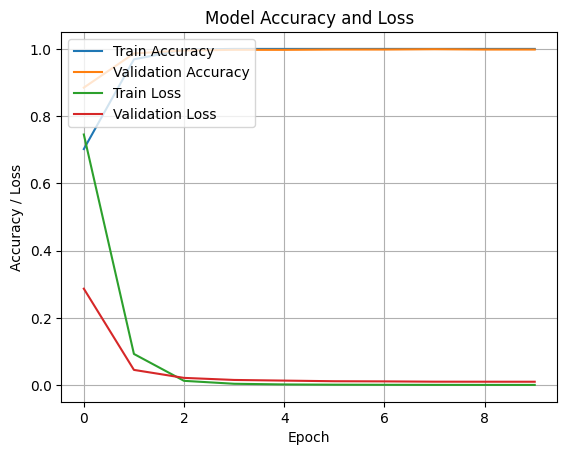

In [10]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Plot Loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')

# Add legend
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)  # Optional for better readability
plt.show()

# Precision, Recall, F1-Score


In [11]:
from sklearn.metrics import classification_report

# Ensure model is in evaluation mode
model.eval()

# Prepare the test data
test_encodings = tokenize_texts(X_test, tokenizer)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Make sure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)  # Adjust for binary classification

        # Convert logits to probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()  # Convert probabilities to binary labels

        # Modify how predictions are extracted from the logits
        preds = torch.argmax(probs, dim=-1)  # Get the class with the highest probability

        # Store true labels and predictions
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

# Generate classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       563
         1.0       1.00      1.00      1.00       549

    accuracy                           1.00      1112
   macro avg       1.00      1.00      1.00      1112
weighted avg       1.00      1.00      1.00      1112



# Confusion Matrix

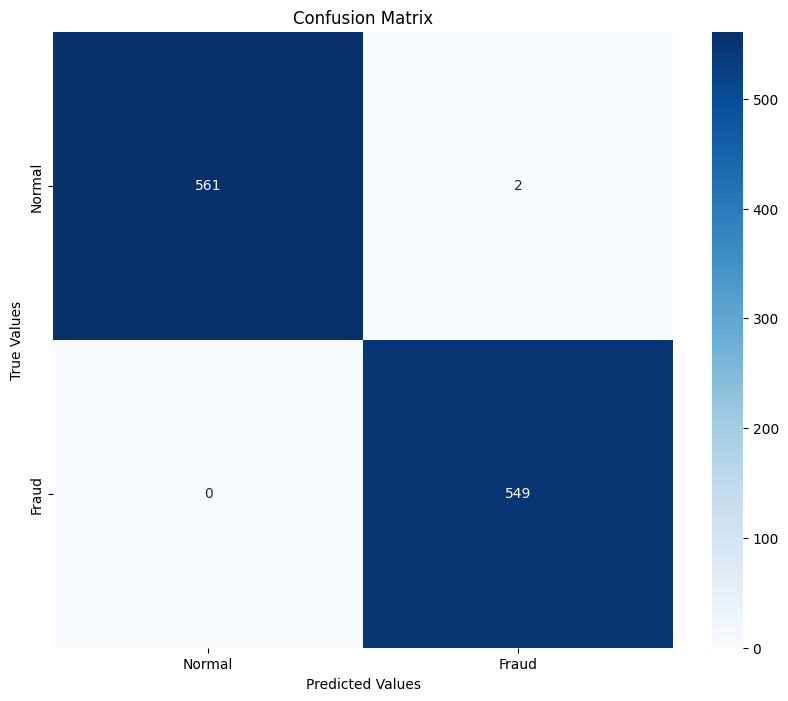

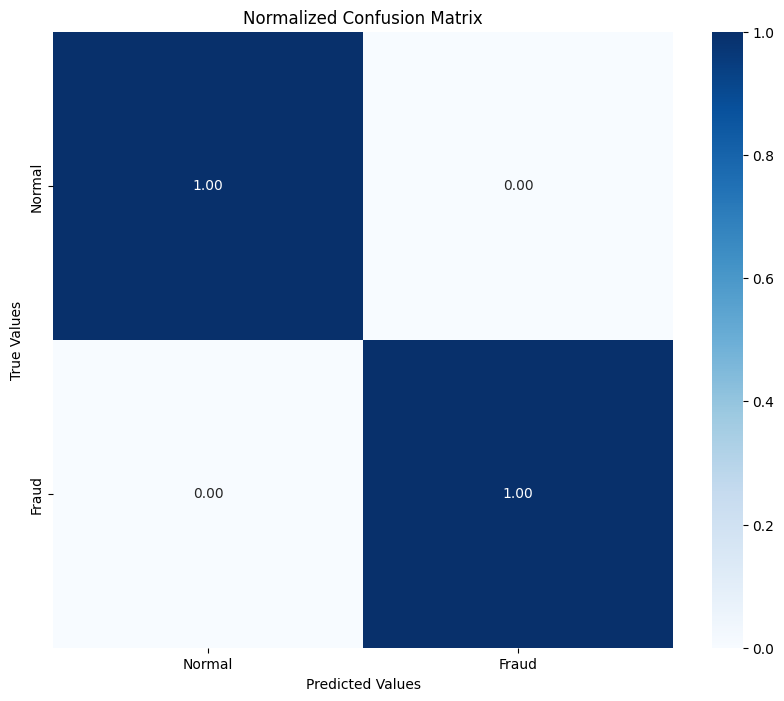

DSC: 0.9982012293756066, Sensitivity: 0.9982238010657194, Specificity: 0.9982238010657194, Accuracy: 0.9982014388489209


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch

def calculate_metrics(y_true, y_pred, classes=['Normal', 'Fraud']):
    """
    Calculate and display various evaluation metrics based on true and predicted labels.

    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.
    - classes: List of class labels (default: ['Normal', 'Fraud']).

    Returns:
    - dsc: Dice similarity coefficient (mean across classes).
    - sensitivity: Mean sensitivity across classes.
    - specificity: Mean specificity across classes.
    - accuracy: Overall accuracy.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Confusion Matrix')
    plt.show()

    # Normalize the confusion matrix by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate the Dice similarity coefficient (DSC) for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])

    # Calculate the sensitivity (recall) for each class and average them
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])

    # Calculate the specificity for each class and average them
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Calculate the overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Print the evaluation metrics
    print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

    return dsc, sensitivity, specificity, accuracy

# Make sure model is in evaluation mode
model.eval()

# Prepare the test data (tokenized input data for PyTorch)
test_encodings = tokenize_texts(X_test, tokenizer)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Ensure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        # Get the predicted probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()  # Use thresholding to get the predicted labels (0 or 1)

        # Modify how predictions are extracted from the logits
        preds = torch.argmax(probs, dim=-1)  # Get the class with the highest probability

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for numpy operations
        predictions.extend(preds.cpu().numpy())   # Move predictions back to CPU for numpy operations

# Calculate metrics
dsc, sensitivity, specificity, accuracy = calculate_metrics(true_labels, predictions)

# K-Folds Cross Validation

In [13]:
import numpy as np
import torch
from sklearn.model_selection import KFold
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Set parameters
k_folds = 5
batch_size = 16
epochs = 5
learning_rate = 1e-5

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125M", cache_dir="./models")
tokenizer.pad_token = tokenizer.eos_token  # Add padding token for GPT models

# Tokenization function
def tokenize_texts(texts, tokenizer, max_length=256):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Prepare your data
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'\nFold {fold + 1}/{k_folds}')

    # Split data
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Tokenize data
    train_encodings = tokenize_texts(X_train_fold, tokenizer)
    val_encodings = tokenize_texts(X_val_fold, tokenizer)

    train_labels = torch.tensor(y_train_fold.values, dtype=torch.long)
    val_labels = torch.tensor(y_val_fold.values, dtype=torch.long)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model for this fold
    model = GPTNeoForSequenceClassification.from_pretrained(
        "EleutherAI/gpt-neo-125M", num_labels=2
    )
    model.config.pad_token_id = tokenizer.eos_token_id
    model.to(device)

    # Define optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    num_training_steps = len(train_loader) * epochs
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=int(0.1 * num_training_steps), num_training_steps=num_training_steps)

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            train_loss += loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        train_accuracy = train_correct / train_total
        print(f"Training Loss: {train_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            val_loss += outputs.loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss / len(val_loader))
    print(f"Validation Accuracy: {val_accuracy:.4f}, Loss: {val_loss / len(val_loader):.4f}")

# Calculate mean and standard deviation of accuracies and losses
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f'\nFinal Results:')
print(f'Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}')



Fold 1/5


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 278/278 [03:28<00:00,  1.33it/s]


Training Loss: 0.4640, Accuracy: 0.7894


Epoch 2: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0287, Accuracy: 0.9933


Epoch 3: 100%|██████████| 278/278 [03:28<00:00,  1.34it/s]


Training Loss: 0.0044, Accuracy: 0.9998


Epoch 4: 100%|██████████| 278/278 [03:28<00:00,  1.34it/s]


Training Loss: 0.0020, Accuracy: 1.0000


Epoch 5: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0014, Accuracy: 1.0000
Validation Accuracy: 0.9982, Loss: 0.0039

Fold 2/5


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 278/278 [03:28<00:00,  1.33it/s]


Training Loss: 0.5273, Accuracy: 0.7667


Epoch 2: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0256, Accuracy: 0.9948


Epoch 3: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0048, Accuracy: 0.9993


Epoch 4: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0021, Accuracy: 0.9998


Epoch 5: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0014, Accuracy: 1.0000
Validation Accuracy: 1.0000, Loss: 0.0027

Fold 3/5


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 278/278 [03:28<00:00,  1.33it/s]


Training Loss: 0.3433, Accuracy: 0.8462


Epoch 2: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0219, Accuracy: 0.9951


Epoch 3: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0040, Accuracy: 0.9998


Epoch 4: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0019, Accuracy: 1.0000


Epoch 5: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0013, Accuracy: 1.0000
Validation Accuracy: 1.0000, Loss: 0.0030

Fold 4/5


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 278/278 [03:28<00:00,  1.33it/s]


Training Loss: 0.5109, Accuracy: 0.7623


Epoch 2: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0246, Accuracy: 0.9948


Epoch 3: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0049, Accuracy: 0.9998


Epoch 4: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0024, Accuracy: 1.0000


Epoch 5: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0018, Accuracy: 1.0000
Validation Accuracy: 0.9964, Loss: 0.0065

Fold 5/5


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 278/278 [03:28<00:00,  1.33it/s]


Training Loss: 0.6481, Accuracy: 0.7580


Epoch 2: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0386, Accuracy: 0.9908


Epoch 3: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0080, Accuracy: 0.9991


Epoch 4: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0034, Accuracy: 1.0000


Epoch 5: 100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Training Loss: 0.0024, Accuracy: 1.0000
Validation Accuracy: 0.9991, Loss: 0.0060

Final Results:
Validation Accuracy: 0.9987 ± 0.0013
Validation Loss: 0.0044 ± 0.0016


# Plotting the K-folds

Folds: 5, Train Acc Entries: 5, Val Acc Entries: 5


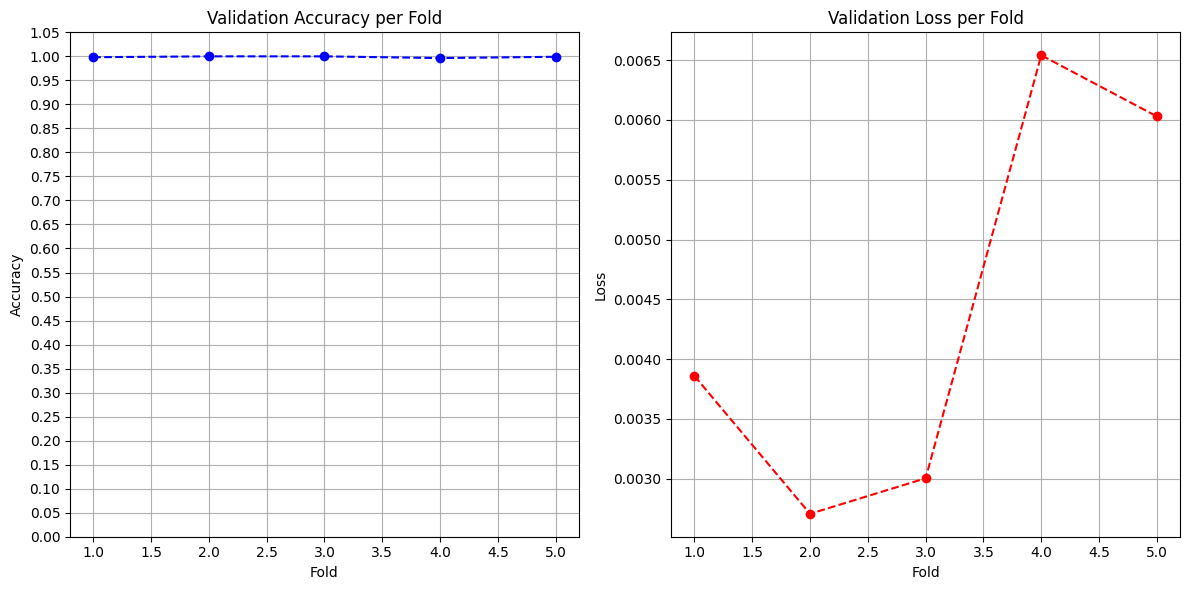

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Number of folds (convert to list to avoid range() issues)
folds = list(range(1, k_folds + 1))

# Ensure number of folds matches recorded metrics
print(f"Folds: {len(folds)}, Train Acc Entries: {len(fold_accuracies)}, Val Acc Entries: {len(fold_losses)}")

# Plot validation accuracies
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(folds, fold_accuracies, marker='o', linestyle='--', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(folds, fold_losses, marker='o', linestyle='--', color='r')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

In [15]:
!pip install transformers torch gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 8.0 MB/s eta 0:00:00


In [16]:
import torch
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification
import gradio as gr

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load tokenizer and trained model
tokenizer = GPT2Tokenizer.from_pretrained("best_gpt_neo")  # Ensure correct tokenizer
model = GPTNeoForSequenceClassification.from_pretrained("best_gpt_neo").to(device)  # Load full model
model.eval()

def classify_caller_message(caller_messages, scam_detected=False):
    scam_threshold = 0.7 if scam_detected else 0.5
    if not caller_messages:
        return "No caller messages to analyze.", scam_detected

    input_text = " ".join([f"Caller: {text}" for text in caller_messages])
    inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    prediction = probabilities[:, 1].item()  # Class 1 probability

    is_scam = prediction > scam_threshold
    response = "🚨 Scam Alert: This message might be a scam!" if is_scam else "✅ Caller message seems safe."
    return response, is_scam

# Gradio Chat Interface
def chat_interface(speaker, message, conversation_log=[], caller_messages=[], scam_detected=False):
    """
    Handles the chat flow while ensuring only the caller's messages affect scam classification.
    """
    conversation_log.append((speaker, message))  # Append to full log

    if speaker == "caller":
        caller_messages.append(message)  # Only keep caller messages for classification
        response, scam_detected = classify_caller_message(caller_messages, scam_detected)
        conversation_log.append(("System", response))
    else:
        response = "✅ Receiver message recorded (ignored for scam detection)."  # Receiver messages do not affect model
        conversation_log.append(("System", response))

    return conversation_log, caller_messages, scam_detected, ""  # Updated states & reset input

# Create Gradio UI
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(label="Conversation Log")
    speaker = gr.Dropdown(["caller", "receiver"], label="Speaker")
    msg = gr.Textbox(placeholder="Enter message...")
    clear = gr.Button("Clear Chat")

    # Maintain separate states
    caller_messages = gr.State([])  # Stores only caller messages
    scam_flag = gr.State(False)  # Tracks scam detection

    msg.submit(chat_interface, [speaker, msg, chatbot, caller_messages, scam_flag],
               [chatbot, caller_messages, scam_flag, msg])

    clear.click(lambda: ([], [], False, ""), outputs=[chatbot, caller_messages, scam_flag, msg])

# Launch Gradio App
demo.launch(share=True)


<ipython-input-16-4eb9ef003eda>:50: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Conversation Log")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f1d78df6190f1cc206.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
